In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2022/train.csv
/kaggle/input/widsdatathon2022/test.csv
/kaggle/input/widsdatathon2022/sample_solution.csv


**Exploratory Data Analysis(EDA):**

The process of investigating the dataset to discover patterns, outliers, and form hypotheses based on our understanding of the dataset is called **Exploratory Data Analysis(EDA)**, it includes clustering and dimension reduction techniques, which help to create graphical displays of high-dimensional data containing variables and univariate visualization of each field in the raw dataset, with summary statistics.

**Introduction:**

Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacted by energy policy and infrastructure. Addressing climate change involves mitigation (i.e. mitigating greenhouse gas emissions) and adaptation (i.e. preparing for unavoidable consequences). Mitigation of GHG emissions requires changes to electricity systems, transportation, buildings, industry, and land use.

According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. For example, retrofitted buildings can reduce heating and cooling energy requirements by 50-90 percent. Many of these energy efficiency measures also result in overall cost savings and yield other benefits, such as cleaner air for occupants. This potential can be achieved while maintaining the services that buildings provide.

**Now we are going to do following tasks:**

Analysing the datasets and we will analyze differences in building energy efficiency, creating models to predict building energy consumption. We will use a dataset consisting of variables that describe building characteristics and climate and weather variables for the regions in which the buildings are located. Accurate predictions of energy consumption can help policymakers target retrofitting efforts to maximize emissions reductions.will submit a solution file containing the predicted Site EUI values for each row in the test dataset




**Files:**
* train.csv - the training dataset where the observed valuse of the Site EUI for each row is provided.
* test_csv - the test dataset where we withhold the observed values of the Site EUI for each row.
* Sample_submission.csv - a sample submission file in the correct format.

**Evaluation Metric:**

* The evaluation metric for this competition is Root Mean Squared Error(RMSE). the RMSE is commonly used measure of the differences between tthe predicted values provided by a model and the actual observed values.

**Importing all the python Open Source packages.**

In [2]:
import os
import gc
import copy

import numpy as np #for array manipulations
import pandas as pd #for manipulation of tabular data
from sklearn.preprocessing import LabelEncoder #sklearn - A package that contains implementation of most of the machine learning algorithms.
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb #for the base line implementation

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size' : 18})
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats

import shap #for machine learning model explainability and interpretability

from sklearn.preprocessing import StandardScaler

import optuna.integration.lightgbm as lgbm
import optuna #optuna for hyper parameter tuning

import warnings
warnings.filterwarnings('ignore')

import wandb

In [3]:
train_set = pd.read_csv('../input/widsdatathon2022/train.csv', encoding = 'unicode_escape')
test_set = pd.read_csv('../input/widsdatathon2022/test.csv', encoding = 'unicode_escape')
categorical_features = ['State_Factor', 'building_class', 'facility_type']
numerical_features = train_set.select_dtypes('number').columns

* The above code is converting csv files to pandas dataframe.


**Analysis of training set:**

In [4]:
train_set.shape

(75757, 64)

* The shape attribute of pandas, it stores the number of rows and columns as a tuple. (number of rows, number of columns) present in train dataset.


In [5]:
train_set.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


* Pandas head() method will return top n (5 by default) rows of a dataframe or series.

In [6]:
train_set.tail()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,48.404398,75754
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,592.022750,75755
75756,6,State_11,Residential,2to4_Unit_Building,23888.0,1974.0,51.0,36.6,27,36.935484,...,16,0,0,0,NaN,NaN,NaN,NaN,29.154684,75756


* Pandas tail() method will return last n (5 by default) rows of a dataframe or series.

In [7]:
train_set.groupby('building_class')['State_Factor'].count().sort_values(ascending=False).head(15)

building_class
Residential    43558
Commercial     32199
Name: State_Factor, dtype: int64

* groupby operation is used to group large amounts of data and compute operations and split data into groups based on some criteria.
* The above code gives an output showing types of and total number of observations of buildings taken for all the states in training set. 

<AxesSubplot:ylabel='State_Factor'>

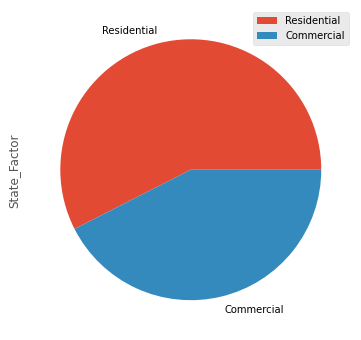

In [8]:
train_set.groupby('building_class')['State_Factor'].count().sort_values(ascending = False).plot(legend = True, kind = 'pie', figsize = (8, 6), title = '')

* The above code gives an output showing which type of building has most observations taken in this datathon training set by representing the data using pie chart.

In [9]:
train_set.groupby('State_Factor')['building_class'].count().sort_values(ascending=False).head(20)

State_Factor
State_6     50840
State_11     6412
State_1      5618
State_2      4871
State_4      4300
State_8      3701
State_10       15
Name: building_class, dtype: int64

* groupby operation is used to group large amounts of data and compute operations and split data into groups based on some criteria.
* The above code gives an output showing number of states and total number of observations including Residential and Commercial buildings taken for each state respectively in train dataset.

<AxesSubplot:ylabel='building_class'>

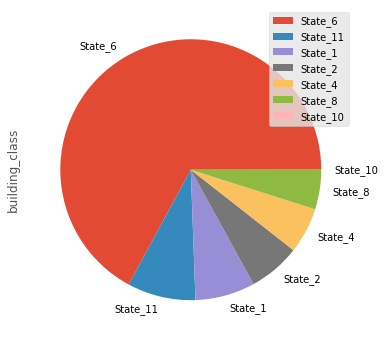

In [10]:
train_set.groupby('State_Factor')['building_class'].count().sort_values(ascending = False).plot(legend = True, kind = 'pie', figsize = (8, 6), title = '')

* The above code gives an output showing which state has most observations taken in this datathon training set by representing the data using pie chart.

**Missing Values**

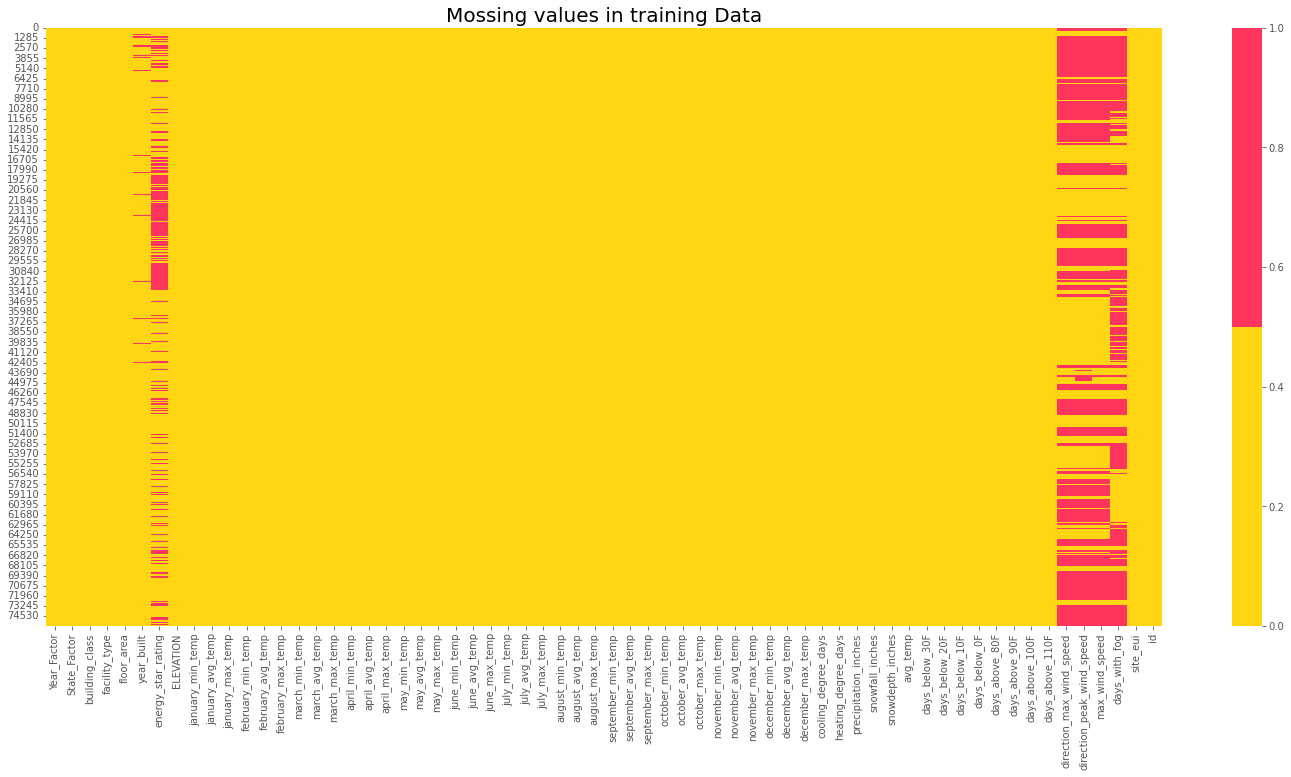

In [11]:
plt.figure(figsize = (25, 11))
sns.heatmap(train_set.isna().values, cmap = ['#ffd514', '#ff355d'], xticklabels = train_set.columns)
plt.title('Mossing values in training Data', size = 20);

* Observing how many columns having the missing values using heatmap for visiual representation.

In [12]:
missing_columns = [col for col in train_set.columns if train_set[col].isnull().any()]
missingvalues_count = train_set.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count')).loc[missingvalues_count.ne(0)]
missingValues_df .style.background_gradient(cmap = 'Pastel1')

,Null Values Count
year_built,1837
energy_star_rating,26709
direction_max_wind_speed,41082
direction_peak_wind_speed,41811
max_wind_speed,41082
days_with_fog,45796


* The output of above code showing fields and the correspoding number of count of the null values respectively.

In [13]:
train_set.describe().style.background_gradient(cmap = "Pastel1")

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,75757.000000,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,165983.865858,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,58.486278,21.606281,44.469292,70.897831,32.037171,53.784863,82.661932,44.706179,63.742547,88.987856,51.131763,71.066384,91.400280,60.571604,76.596879,95.543950,58.515068,75.348749,92.572581,50.791689,69.597545,92.171139,38.210911,58.727038,81.135671,28.630397,48.123133,71.202397,22.736777,41.625569,64.496852,1202.250446,4324.957390,42.430651,29.136379,164.862455,56.176705,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,246875.790940,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,8.414611,10.004303,6.657142,7.680982,5.577279,2.500473,4.101028,4.200319,2.792919,2.864669,3.415926,2.861681,3.604068,4.177109,4.090275,4.157118,4.441992,3.818895,4.139685,4.290884,3.603773,5.011708,5.093899,2.641300,5.579513,7.153244,4.094207,4.373374,9.014047,5.869386,6.054104,391.561780,824.366727,10.592205,17.810894,175.275869,2.241940,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,943.000000,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,-9.000000,25.854839,53.000000,15.000000,40.280000,62.000000,23.000000,46.950000,64.000000,30.000000,54.100000,67.000000,37.000000,54.822581,65.000000,31.000000,56.693548,66.000000,26.000000,53.600000,64.000000,18.000000,44.693548,59.000000,4.000000,30.766667,53.000000,-16.000000,23.790323,42.000000,0.000000,398.000000,0.000000,0.000000,0.000000,44.512329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,62379.000000,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,55.000000,13.000000,38.096774,62.000000,26.000000,52.333333,80.000000,42.000000,62.790323,88.000000,50.000000,70.983333,89.000000,57.000000,76.145161,95.000000,57.000000,74.516129,90.000000,47.000000,68.200000,91.000000,35.000000,58.048387,78.000000,23.000000,45.250000,69.000000,17.000000,38.532258,60.000000,1128.000000,3978

* The above code showing the Descriptive values of the training dataset.

**Observations made from Training Set:**

The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to the a single building observed in a given year.

* The training dataset where the observed values of the Site EUI for each row is provided.
* The total observations are taken from 7 states and for 6 years respectively.
* There are two catagories of buildings mentioned in the building_class 1)Commercial 2)Residential

**Data Dictionary**

**Covariates**
id: building id

* Year_Factor: anonymized year in which the weather and energy usage factors were observed

* State_Factor: anonymized state in which the building is located
 
* building_class: building classification
 
* facility_type: building usage type

* floor_area: floor area (in square feet) of the building
 
* year_built: year in which the building was constructed
 
* energy_star_rating: the energy star rating of the building
 
* ELEVATION: elevation of the building location
 
* january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building
 
* january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building
 
* january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building
 
* cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.
 
* heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.
 
* precipitation_inches: annual precipitation in inches at the location of the building
 
* snowfall_inches: annual snowfall in inches at the location of the building
 
* snowdepth_inches: annual snow depth in inches at the location of the building
 
* avg_temp: average temperature over a year at the location of the building
 
* days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building
 
* days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building
 
* days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building
 
* days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building
 
* days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building
 
* days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building
 
* days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building
 
* days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building
 
* direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).
 
* direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).
 
* max_wind_speed: maximum wind speed at the location of the building
 
* days_with_fog: number of days with fog at the location of the building

**Target**

* site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills


**Analysis of Test set:**

In [14]:
test_set.shape

(9705, 63)

* The shape attribute of pandas, it stores the number of rows and columns as a tuple. (number of rows, number of columns) present in tset dataset.

In [15]:
test_set.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


* Pandas head() method will return top n (5 by default) rows of a dataframe or series.

In [16]:
test_set.tail()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
9700,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.66129,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85457
9701,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.66129,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85458
9702,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.66129,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85459
9703,7,State_11,Residential,5plus_Unit_Building,25368.0,1992.0,79.0,812.0,21,38.66129,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85460
9704,7,State_11,Residential,5plus_Unit_Building,45640.0,1994.0,87.0,26.5,21,38.66129,...,0,39,3,0,0,NaN,NaN,NaN,NaN,85461


* Pandas tail() method will return last n (5 by default) rows of a dataframe or series.

In [17]:
test_set.groupby('building_class')['State_Factor'].count().sort_values(ascending=False).head(15)

building_class
Commercial     5607
Residential    4098
Name: State_Factor, dtype: int64

* groupby operation is used to group large amounts of data and compute operations and split data into groups based on some criteria.
* The above code gives an output showing types of and total number of observations of buildings taken for all the states in test dataset.

<AxesSubplot:ylabel='State_Factor'>

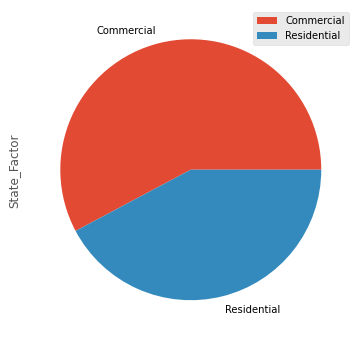

In [18]:
test_set.groupby('building_class')['State_Factor'].count().sort_values(ascending = False).plot(legend = True, kind = 'pie', figsize = (8, 6), title = '')

* The above code gives an output showing which type of building has most observations taken in this datathon training set by representing the data using pie chart.

In [19]:
test_set.groupby('State_Factor')['building_class'].count().sort_values(ascending=False).head(20)

State_Factor
State_11    3268
State_4     2568
State_2     1515
State_8     1323
State_1     1027
State_10       4
Name: building_class, dtype: int64

* groupby operation is used to group large amounts of data and compute operations and split data into groups based on some criteria.
* The above code gives an output showing number of states and total number of observations including Residential and Commercial buildings taken for each state respectively.The above code gives an output showing types of and total number of observations of buildings taken for all the states in test dataset.

<AxesSubplot:ylabel='building_class'>

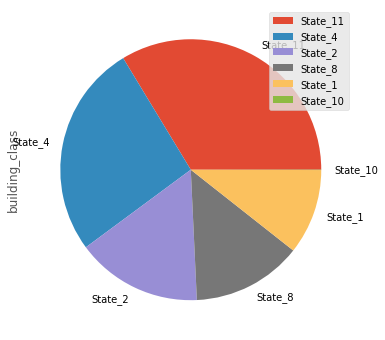

In [20]:
test_set.groupby('State_Factor')['building_class'].count().sort_values(ascending = False).plot(legend = True, kind = 'pie', figsize = (8, 6), title = '')

* The above code gives an output showing which state has most observations taken in this datathon training set by representing the data using pie chart.

**Observations made from test Dataset:**

The dataset consists of building characteristics (e.g. floor area, facility type etc), weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc) as well as the Id. Each row in the data corresponds to the a single building observed in a given year.

* The training dataset where the observed values of the Id for each row is provided.
* The total observations are taken from 6 states and for only one year respectively.
* There are two types of buildings mentioned in the building_class 1)Commercial 2)Residential

* The test dataset where it withhold the observed values of the Id for each row.We have to submit a solution file containing the predicted Site EUI values for each row in the test dataset.
* Our task is to predict the Site EUI for each row, given the characteristics of the building and the weather data for the location of the building.

**Visualiztion with the target variable from training set:**

Target variable distribution

<AxesSubplot:xlabel='site_eui'>

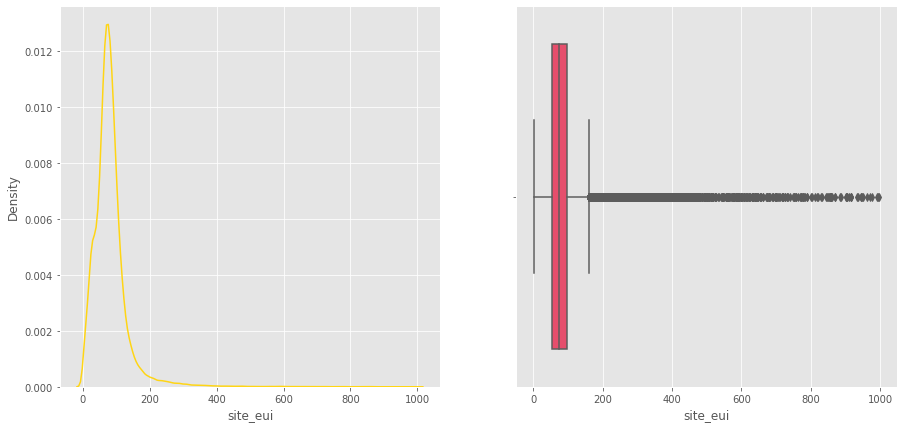

In [21]:
plt.figure(figsize = (15, 7))
plt.subplot(121)
sns.kdeplot(train_set.site_eui, color = '#ffd514')
plt.subplot(122)
sns.boxplot(train_set.site_eui, color = '#ff355d')

* The ouput of the above code representing the distribution of the target variable using boxplot and kdeplot(KDE - Kernal Density Estimate).

**Distribution of Numeric Variables**

In [22]:
def kdeplot_features(df_train, df_test, feature, title):
    # Take a column from dataframe and plots the distribution (after count)
    values_train = df_train[feature].to_numpy()
    values_test = df_test[feature].to_numpy()
    plt.figure(figsize = (18, 3))
    
    sns.kdeplot(values_train, color = '#ffd514')
    sns.kdeplot(values_test, color = '#ff355d')
    
    plt.title(title, fontsize = 15)
    plt.legend()
    plt.show();
    del values_train, values_test
    gc.collect()
    
def countplot_features(df_train, feature, title):
    #Take a column from dataframe and plots the distribution (after count)
    plt.figure(figsize = (18, 5))
    sns.countplot(df_train[feature], color = "#ff355d")
    
    plt.title(title, fontsize = 15)
    plt.show();

def create_wandb_hist(x_data = None, x_name = None, title = None, log = None):
    '''Create and save histogram in W&B environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    data = [[x] for x in data]
    table = wandb.Table(data = data, columns = [x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title = title)})

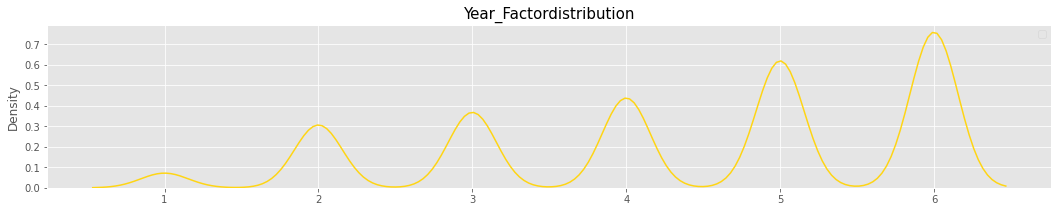

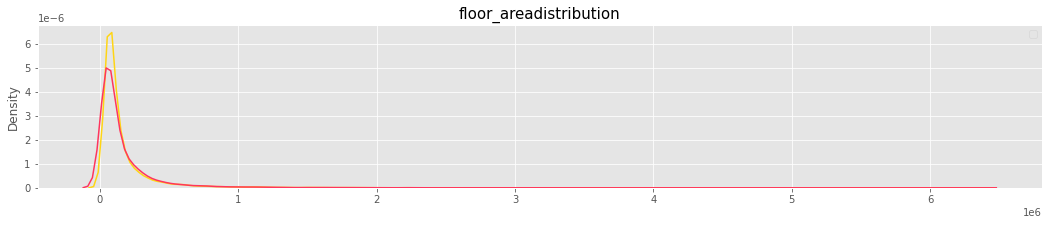

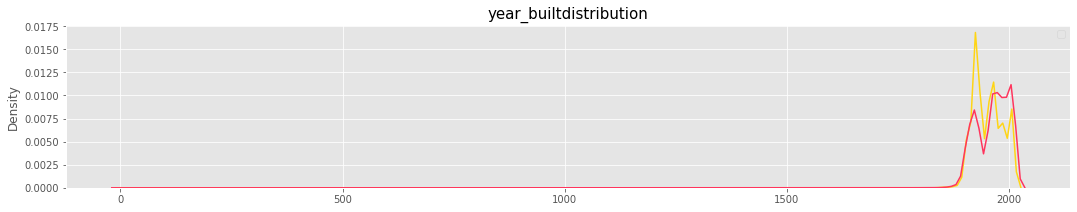

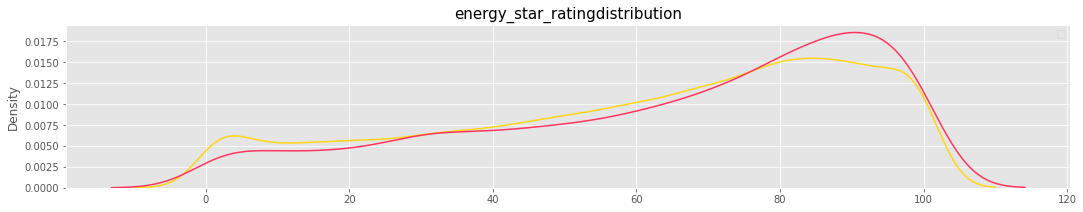

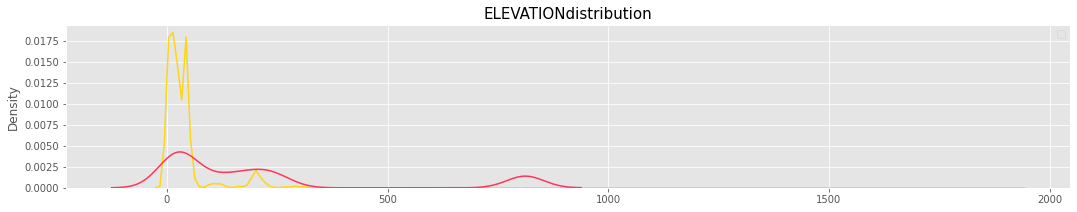

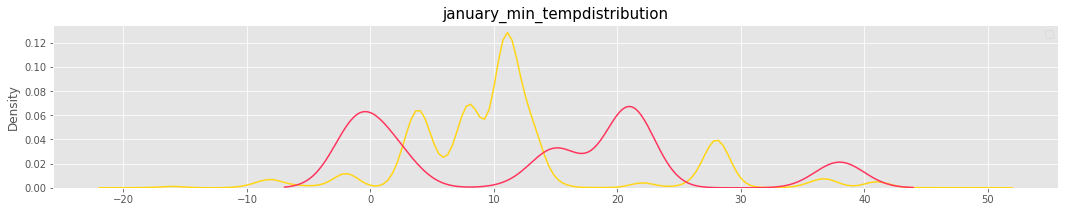

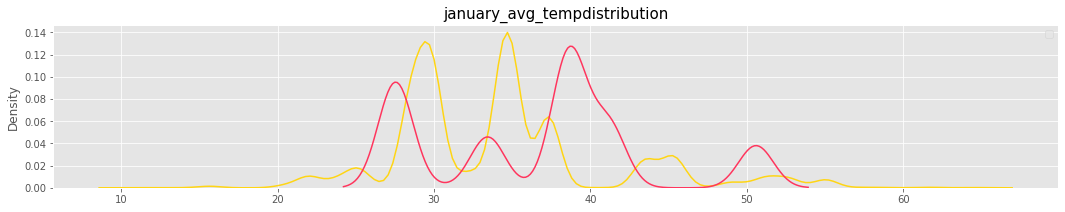

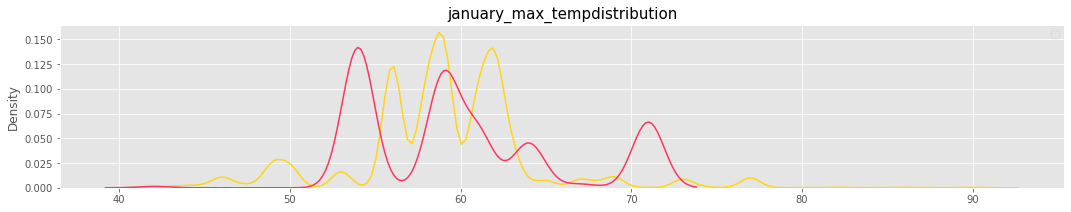

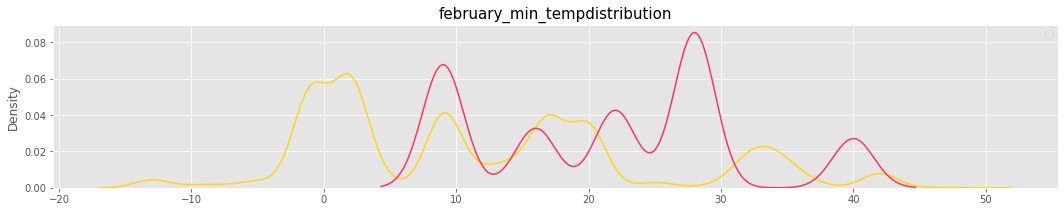

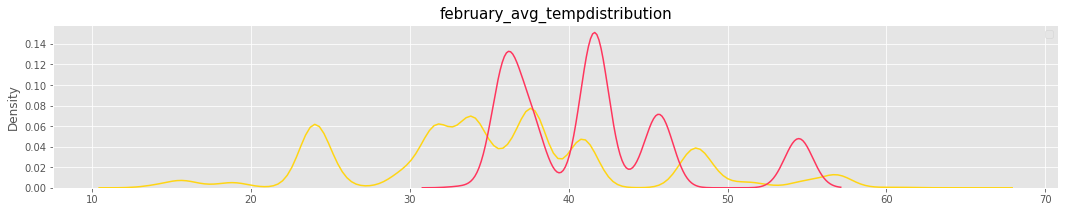

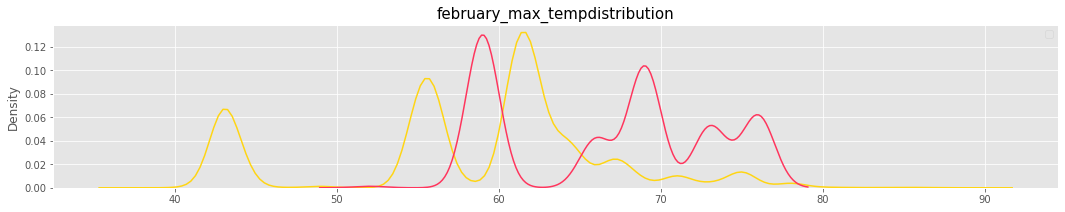

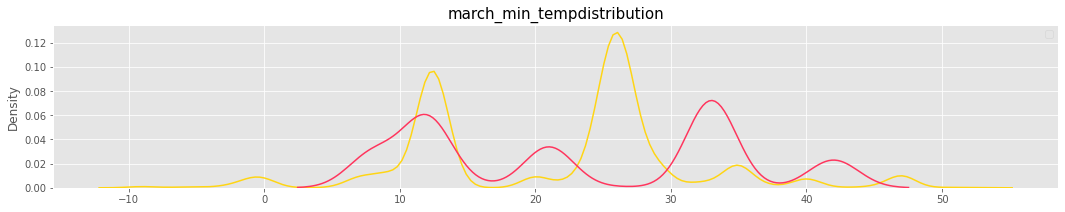

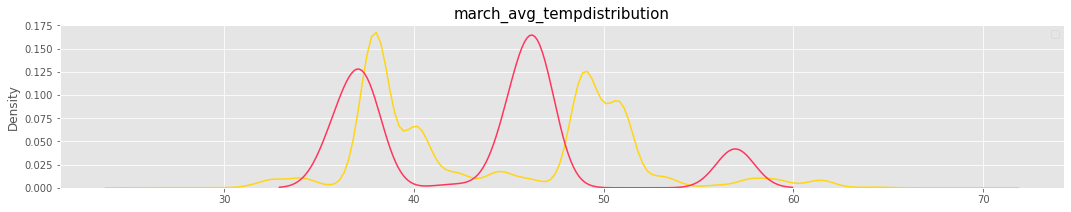

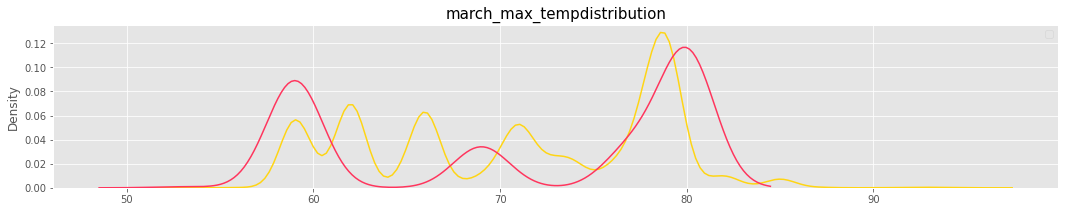

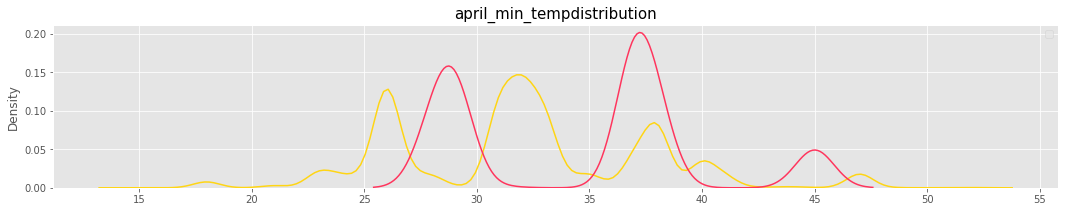

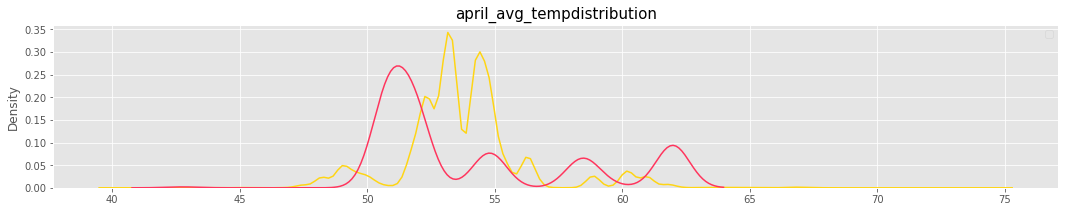

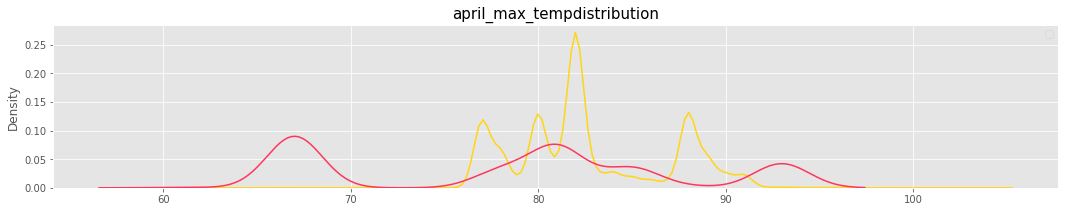

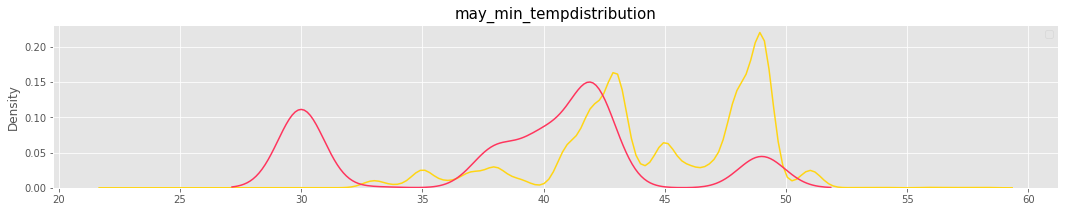

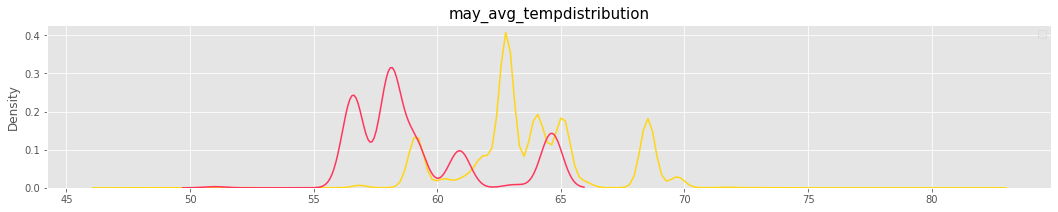

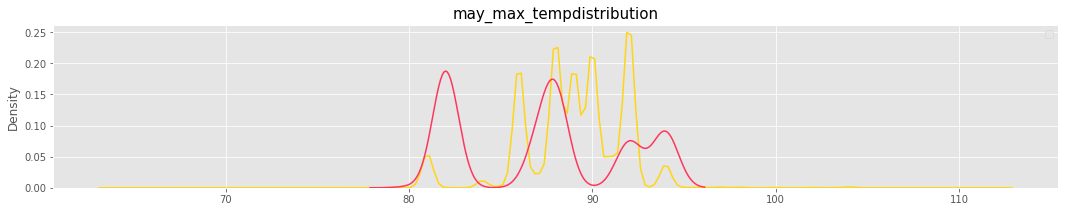

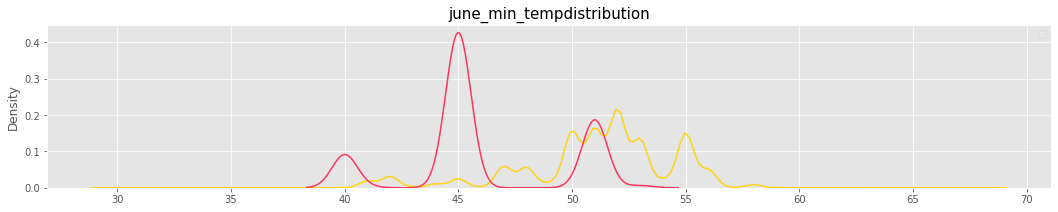

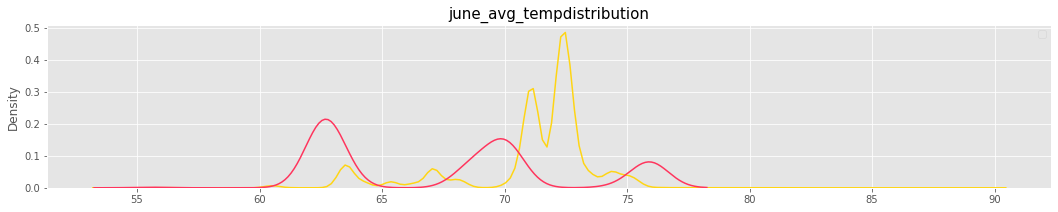

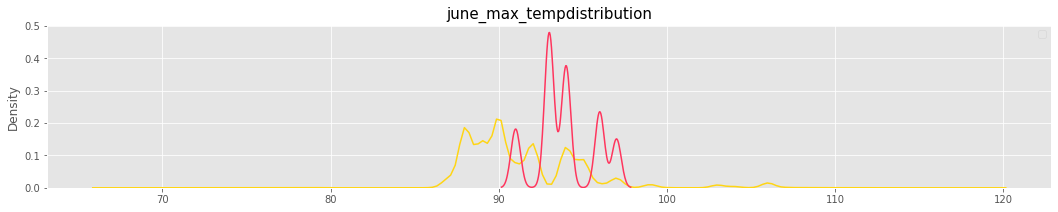

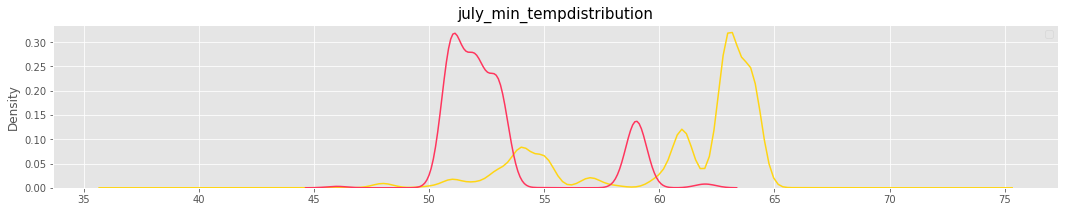

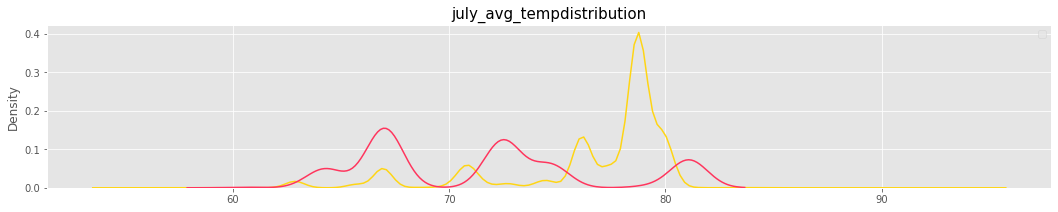

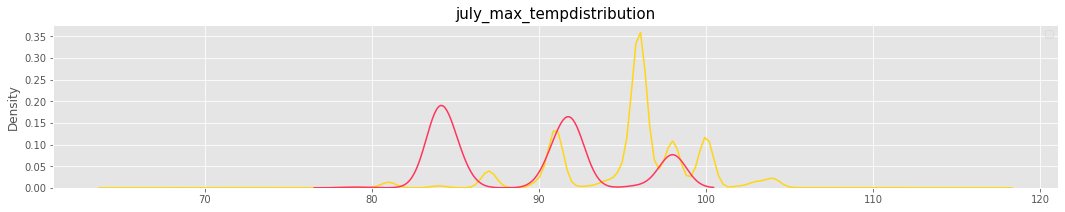

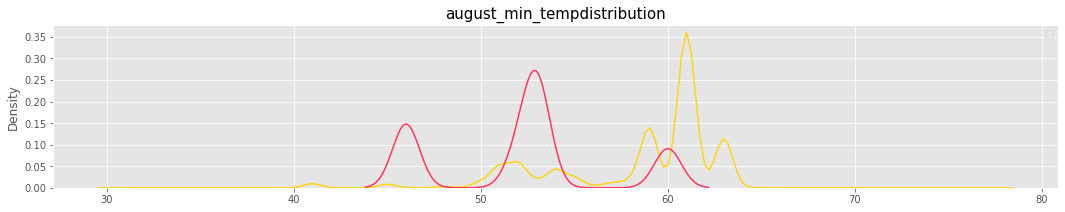

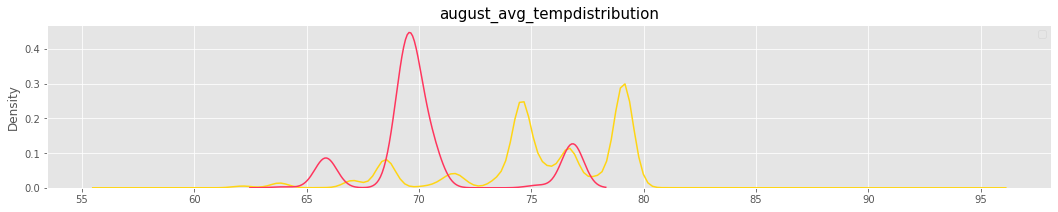

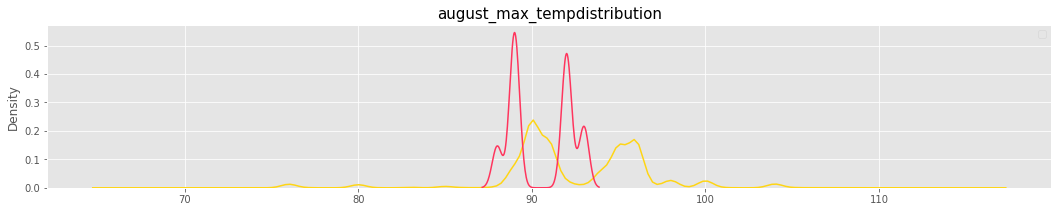

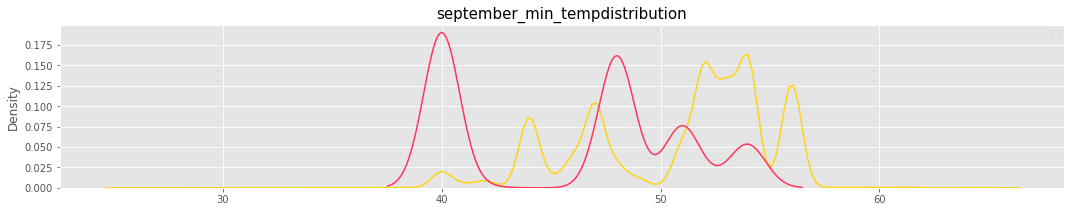

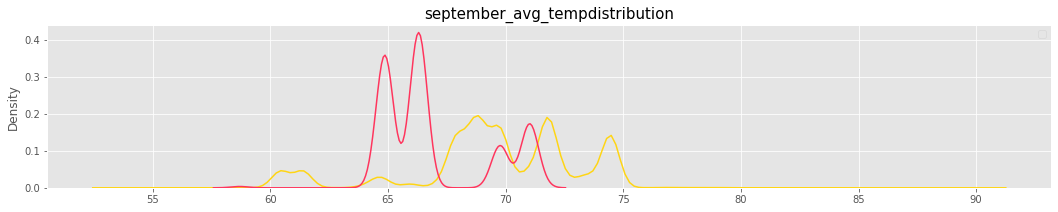

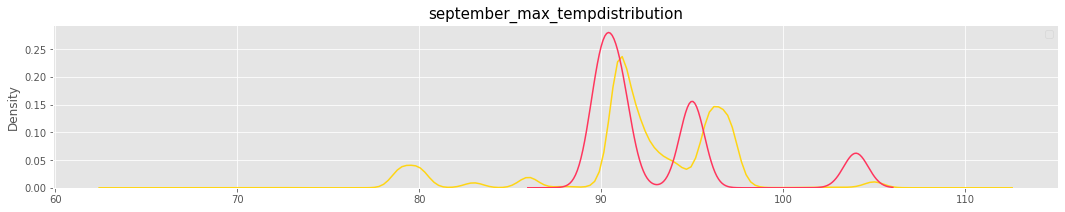

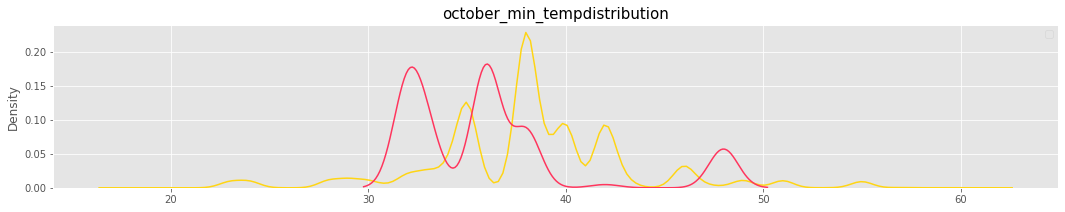

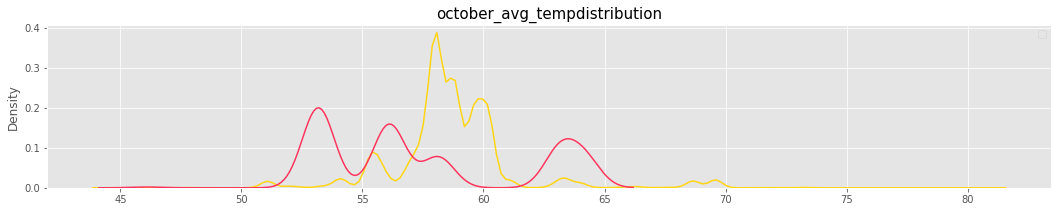

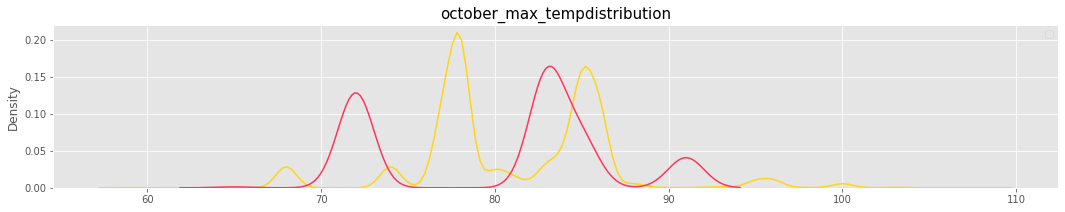

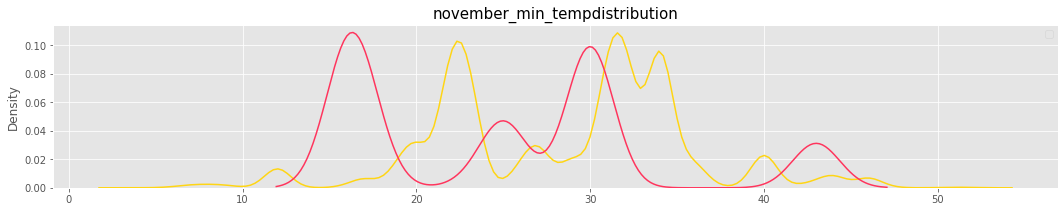

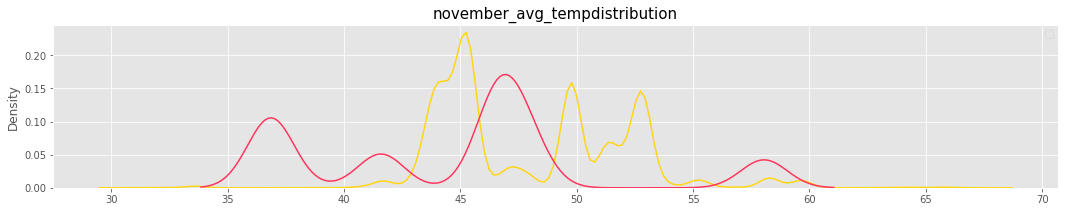

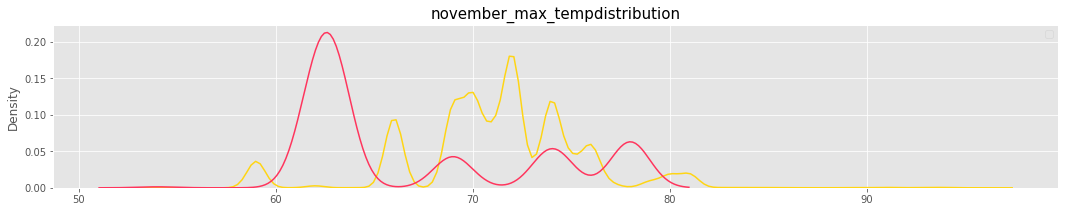

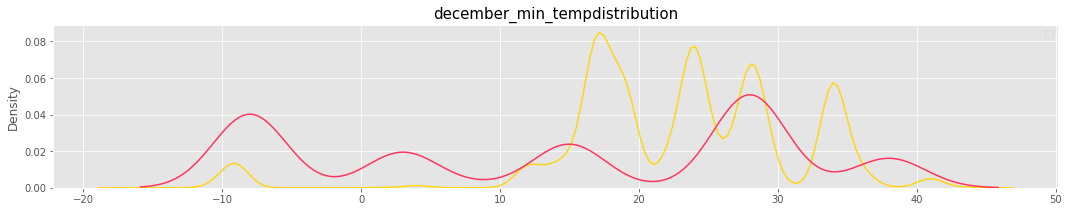

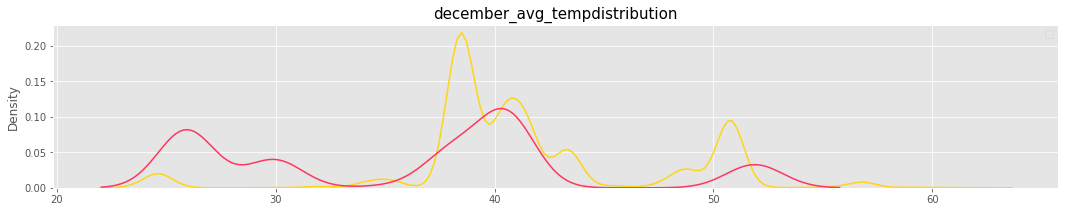

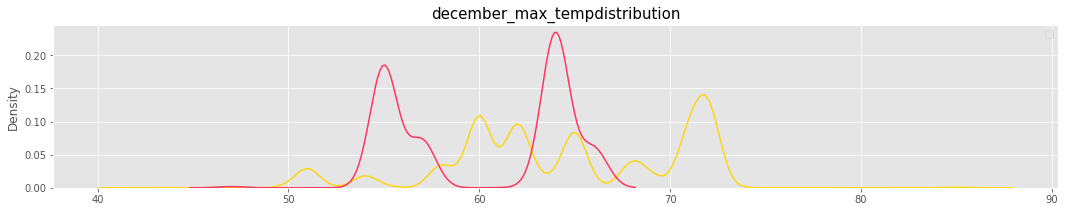

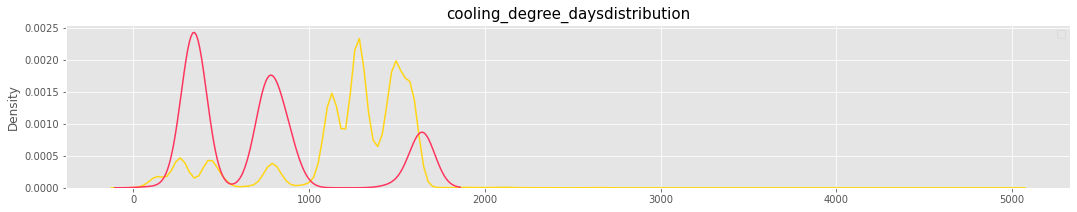

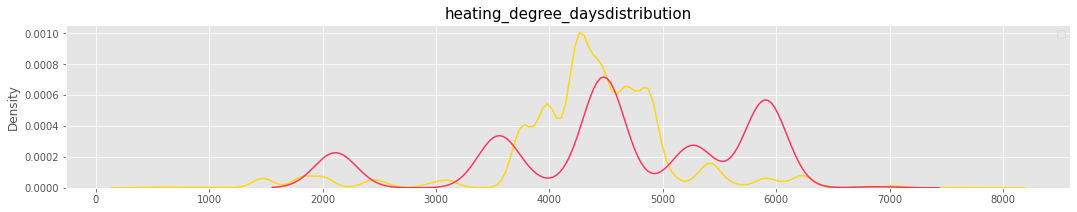

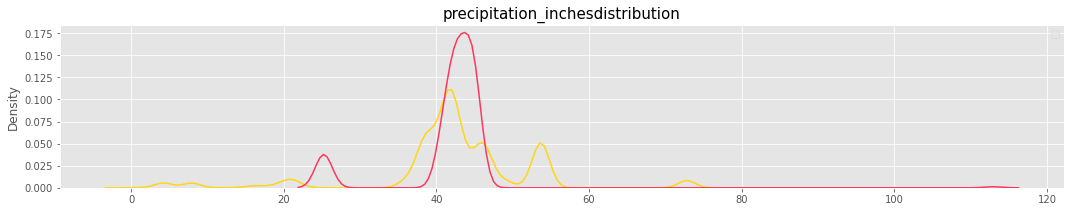

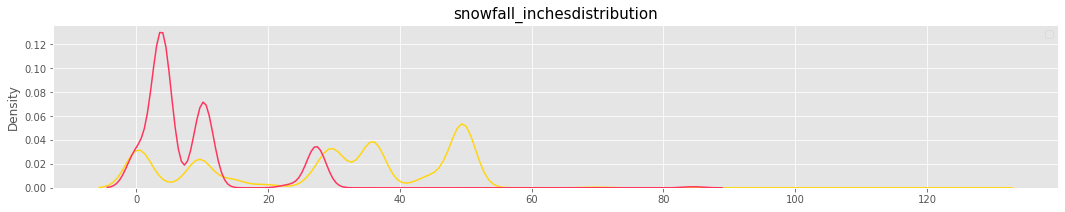

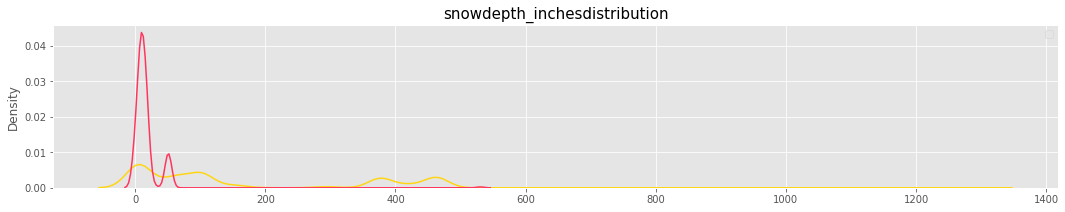

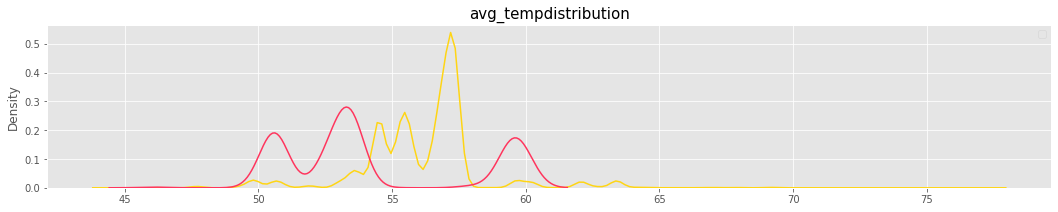

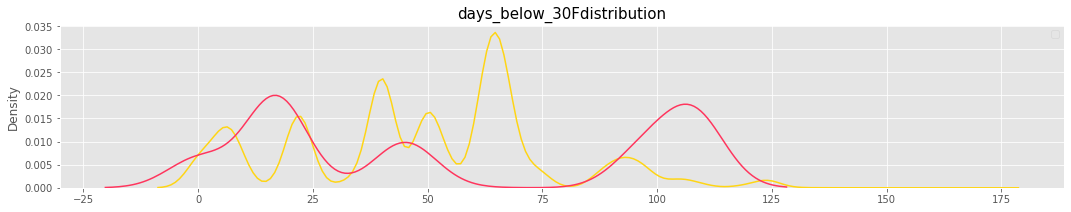

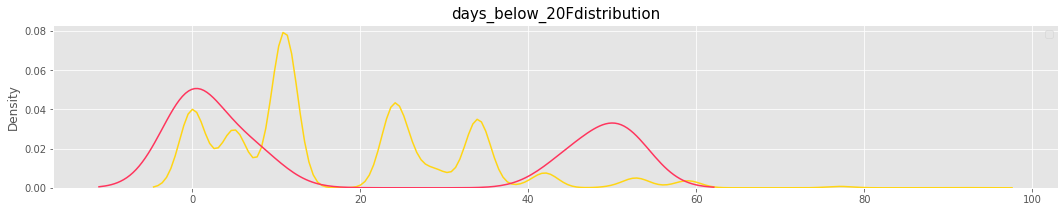

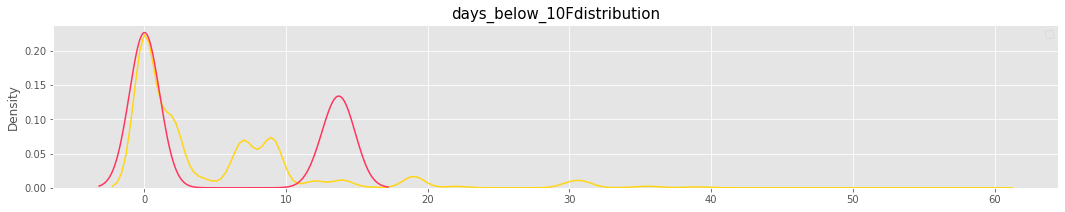

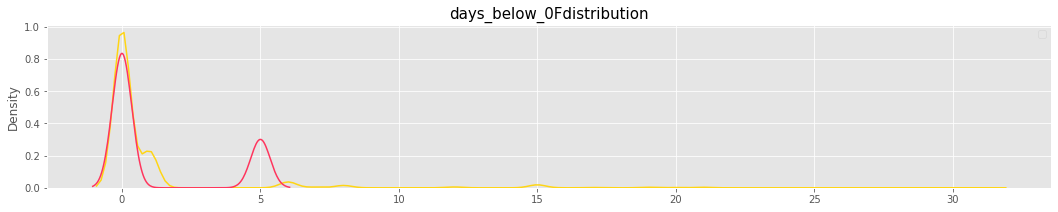

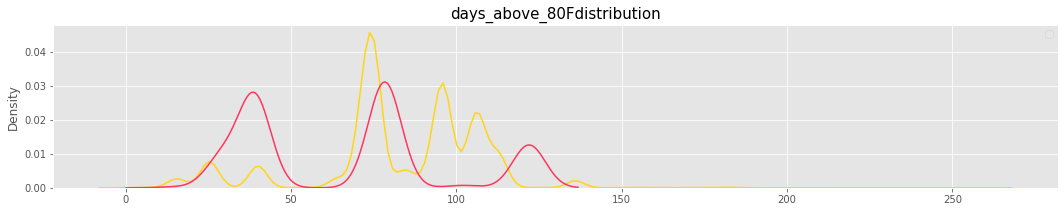

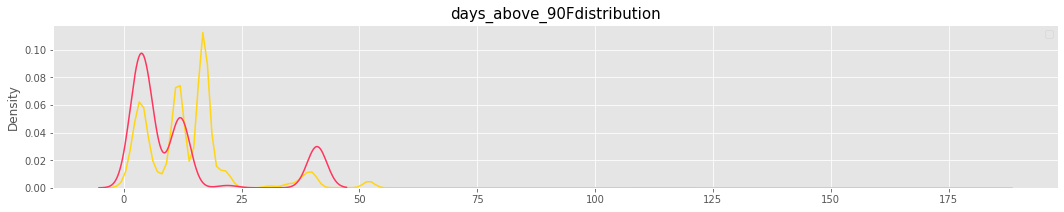

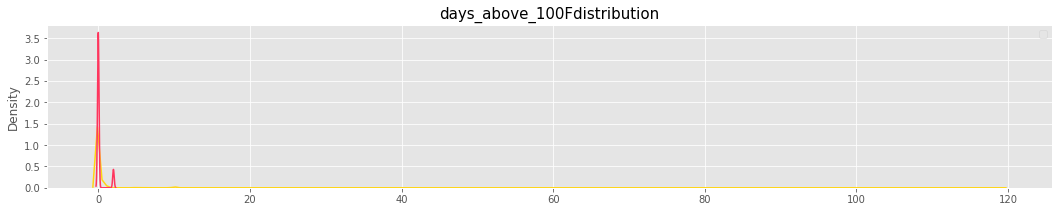

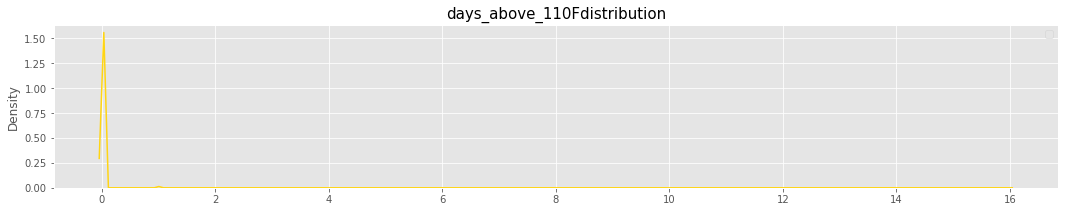

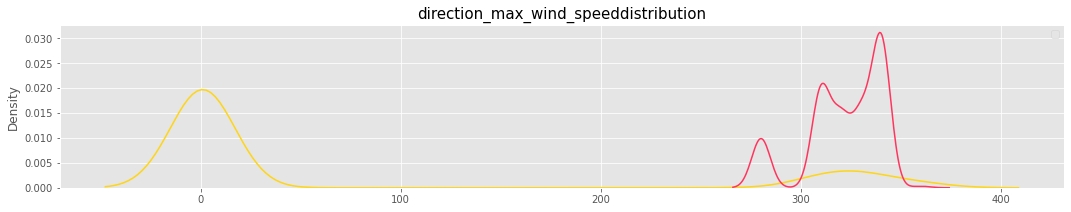

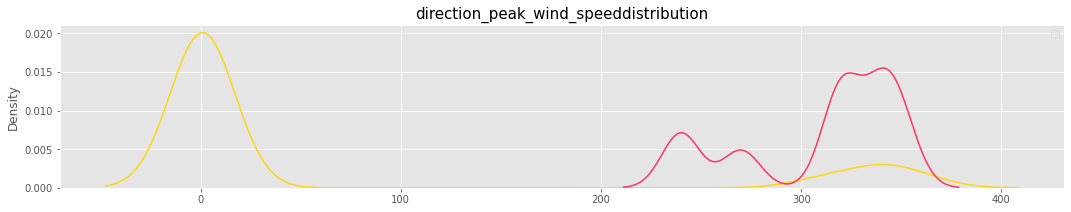

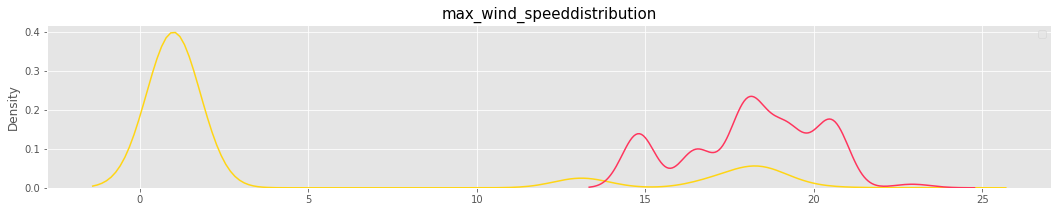

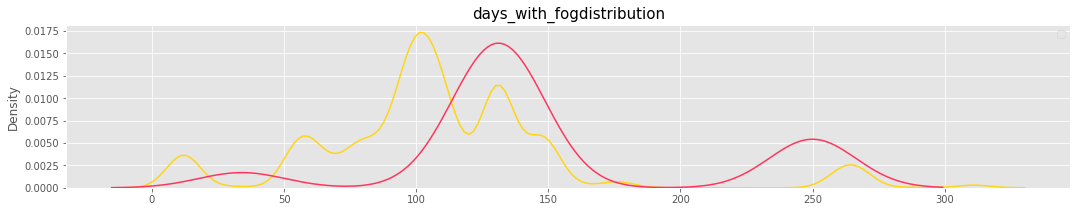

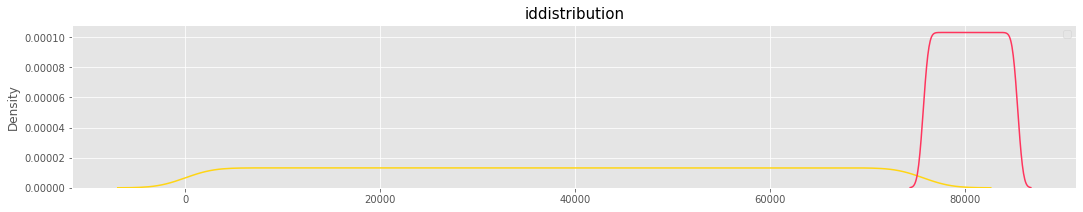

In [23]:
for feature in numerical_features:
    if feature != 'site_eui':
        kdeplot_features(train_set, test_set, feature = feature, title = feature + "distribution")

* The above plot showing the distribution of features.
* the above cide is taking each and every numerical variable and exploring the distribution of the variable in the training dataset and the test dataset.

**Distribution of Categorical Variables**

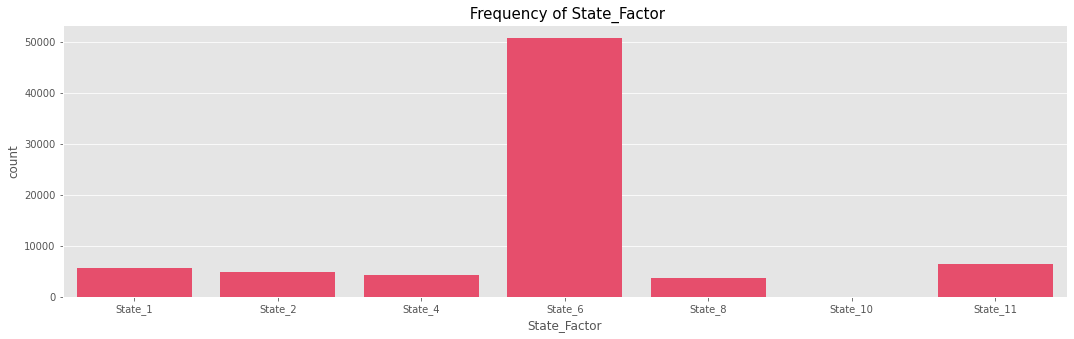

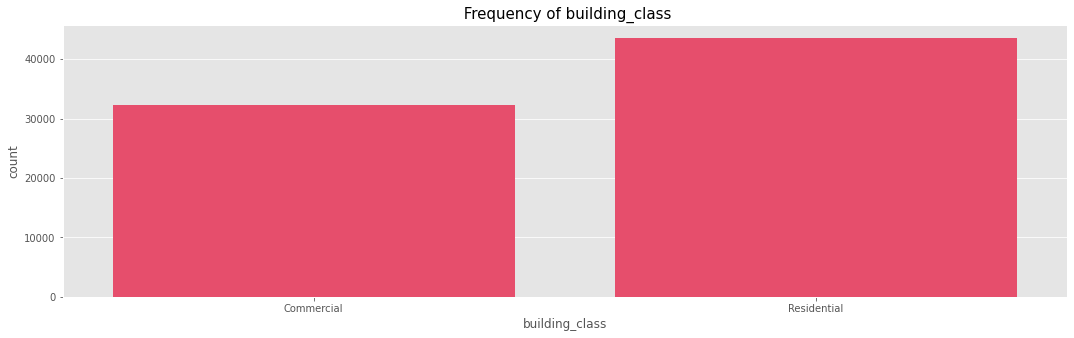

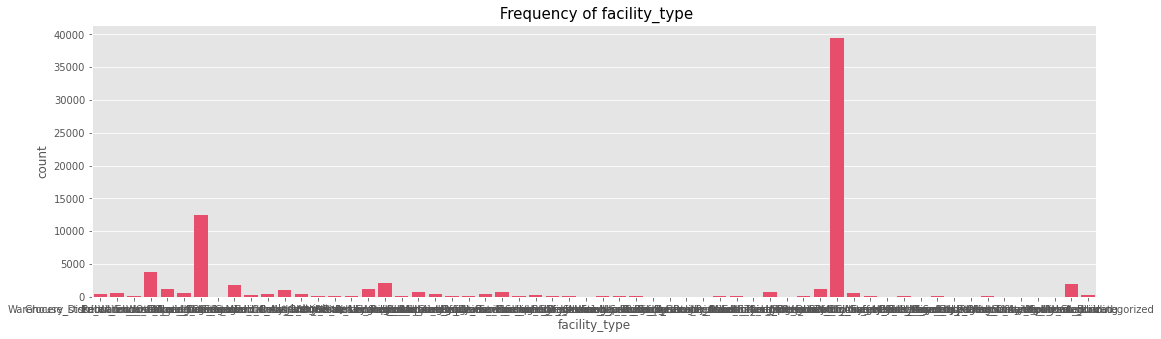

In [24]:
for feature in categorical_features:
    fig = countplot_features(train_set, feature = feature, title = " Frequency of " + feature)

* The above plot showing the plot distribution of categorical features.